In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sentence_transformers import SentenceTransformer
from collections import Counter
import re
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 10)

def load_data():
    """Load and prepare the UCI Online Retail dataset"""
    print("Loading dataset...")
    
    # Fetch the dataset
    online_retail = fetch_ucirepo(id=352)
    
    # Create full dataframe
    df = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)
    print(f"Dataset loaded with shape: {df.shape}")
    
    return df

def preprocess_data(df):
    """Clean and preprocess the data"""
    print("Preprocessing data...")
    
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Remove rows with missing product descriptions
    df_clean = df_clean.dropna(subset=['Description'])
    
    # Filter out canceled invoices (invoices starting with 'C')
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
    
    # Convert invoice date to datetime
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # Filter out entries with non-positive quantities or prices
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
    
    print(f"After cleaning, dataset shape: {df_clean.shape}")
    return df_clean

In [5]:
def classify_product(description):
    """
    Classify products into categories based on keywords in their descriptions
    """
    # Convert to lowercase for case-insensitive matching
    description = str(description).lower()
    
    # Define categories and their associated keywords
    categories = {
        'Kitchen & Dining': ['kitchen', 'dining', 'cook', 'bake', 'plate', 'cup', 'mug', 'bowl', 'spoon', 
                          'fork', 'knife', 'dish', 'glass', 'teapot', 'coffee', 'tea', 'jar', 'lunch',
                          'dinner', 'breakfast', 'chef', 'apron', 'oven', 'kitchen', 'utensil', 'spatula'],
        
        'Home Decor': ['decor', 'decoration', 'ornament', 'frame', 'candle', 'vase', 'cushion', 'pillow',
                      'throw', 'lamp', 'light', 'clock', 'wall', 'shelf', 'mirror', 'lantern', 'holder',
                      'decorative', 'design', 'interior', 'vintage', 'retro', 'modern', 'ceramic'],
        
        'Garden & Outdoor': ['garden', 'outdoor', 'plant', 'flower', 'bird', 'animal', 'water', 'grow',
                           'pot', 'seed', 'lawn', 'patio', 'deck', 'bbq', 'picnic', 'summer',
                           'welcome', 'doormat', 'insect', 'watering'],
        
        'Seasonal & Holiday': ['christmas', 'easter', 'halloween', 'valentine', 'birthday', 'wedding',
                              'anniversary', 'holiday', 'festival', 'celebration', 'party', 'santa',
                              'xmas', 'tree', 'december', 'snow', 'winter', 'autumn', 'spring'],
        
        'Storage & Organization': ['storage', 'box', 'basket', 'bag', 'organize', 'container', 'tin',
                                 'case', 'chest', 'drawer', 'hook', 'hanger', 'rack', 'shelf',
                                 'store', 'tidy', 'collect'],
        
        'Children & Toys': ['child', 'kid', 'baby', 'toy', 'play', 'game', 'doll', 'teddy', 'bear',
                          'robot', 'car', 'animal', 'dinosaur', 'school', 'learn', 'education',
                          'young', 'junior', 'infant', 'girl', 'boy'],
        
        'Bath & Beauty': ['bath', 'shower', 'soap', 'beauty', 'cosmetic', 'makeup', 'wash', 'clean',
                        'towel', 'toilet', 'bathroom', 'spa', 'relax', 'refresh', 'scent', 'perfume',
                        'fragrance', 'lotion', 'cream', 'oil'],
        
        'Stationery & Gifts': ['stationery', 'pen', 'pencil', 'paper', 'card', 'gift', 'present',
                             'notebook', 'journal', 'diary', 'office', 'desk', 'tape', 'scissor',
                             'envelope', 'wrap', 'ribbon', 'tag', 'label', 'sign', 'post'],
        
        'Fashion & Accessories': ['fashion', 'accessory', 'jewelry', 'necklace', 'bracelet', 'earring',
                                'ring', 'watch', 'scarf', 'hat', 'cap', 'glove', 'purse', 'handbag',
                                'wallet', 'sunglasses', 'umbrella', 'wear', 'clothes']
    }
    
    # Check for category matches
    for category, keywords in categories.items():
        # Use word boundary checks to avoid partial matches
        for keyword in keywords:
            # Check if the keyword is a whole word in the description
            if re.search(r'\b' + keyword + r'\b', description):
                return category
    
    # Default category if no keywords match
    return "Miscellaneous"

def prepare_product_data(df):
    """Extract unique products and classify them"""
    print("Preparing product data...")
    
    # Extract unique products
    unique_products = df[['StockCode', 'Description']].drop_duplicates()
    print(f"Number of unique products: {len(unique_products)}")
    
    # If dataset is very large, sample a subset for visualization
    max_products = 5000
    if len(unique_products) > max_products:
        unique_products = unique_products.sample(max_products, random_state=42)
        print(f"Sampled {max_products} products for visualization")
    
    # Classify products
    unique_products['Category'] = unique_products['Description'].apply(classify_product)
    
    # Print category distribution
    category_counts = unique_products['Category'].value_counts()
    print("\nCategory distribution:")
    for category, count in category_counts.items():
        print(f"  {category}: {count} products ({count/len(unique_products)*100:.1f}%)")
    
    # Get product descriptions and categories
    descriptions = unique_products['Description'].tolist()
    categories = unique_products['Category'].tolist()
    stock_codes = unique_products['StockCode'].tolist()
    
    return descriptions, categories, stock_codes, unique_products

def create_embeddings(texts, model_name='all-MiniLM-L6-v2'):
    """Create embeddings using a small Sentence Transformer model"""
    print(f"\nLoading embedding model: {model_name}")
    model = SentenceTransformer(model_name)
    
    # Clean texts before embedding
    cleaned_texts = []
    for text in texts:
        # Convert to string and remove unusual characters
        text = str(text)
        text = ''.join(c for c in text if c.isprintable())
        cleaned_texts.append(text)
    
    print("Creating embeddings...")
    embeddings = model.encode(cleaned_texts, show_progress_bar=True)
    print(f"Embeddings created with shape: {embeddings.shape}")
    
    return embeddings

Loading dataset...
Dataset loaded with shape: (541909, 8)
Preprocessing data...
After cleaning, dataset shape: (530104, 8)
Preparing product data...
Number of unique products: 4161

Category distribution:
  Miscellaneous: 1173 products (28.2%)
  Home Decor: 978 products (23.5%)
  Kitchen & Dining: 574 products (13.8%)
  Stationery & Gifts: 298 products (7.2%)
  Storage & Organization: 288 products (6.9%)
  Garden & Outdoor: 263 products (6.3%)
  Seasonal & Holiday: 246 products (5.9%)
  Fashion & Accessories: 211 products (5.1%)
  Children & Toys: 77 products (1.9%)
  Bath & Beauty: 53 products (1.3%)

Loading embedding model: all-MiniLM-L6-v2
Creating embeddings...


Batches: 100%|██████████| 131/131 [00:07<00:00, 16.86it/s]


Embeddings created with shape: (4161, 384)

Applying dimensionality reduction techniques...
Running t-SNE...
Running UMAP...
Running PCA...
Dimensionality reduction completed.

Creating comparison visualizations...
Comparison visualization saved as 'dimensionality_reduction_comparison.png'


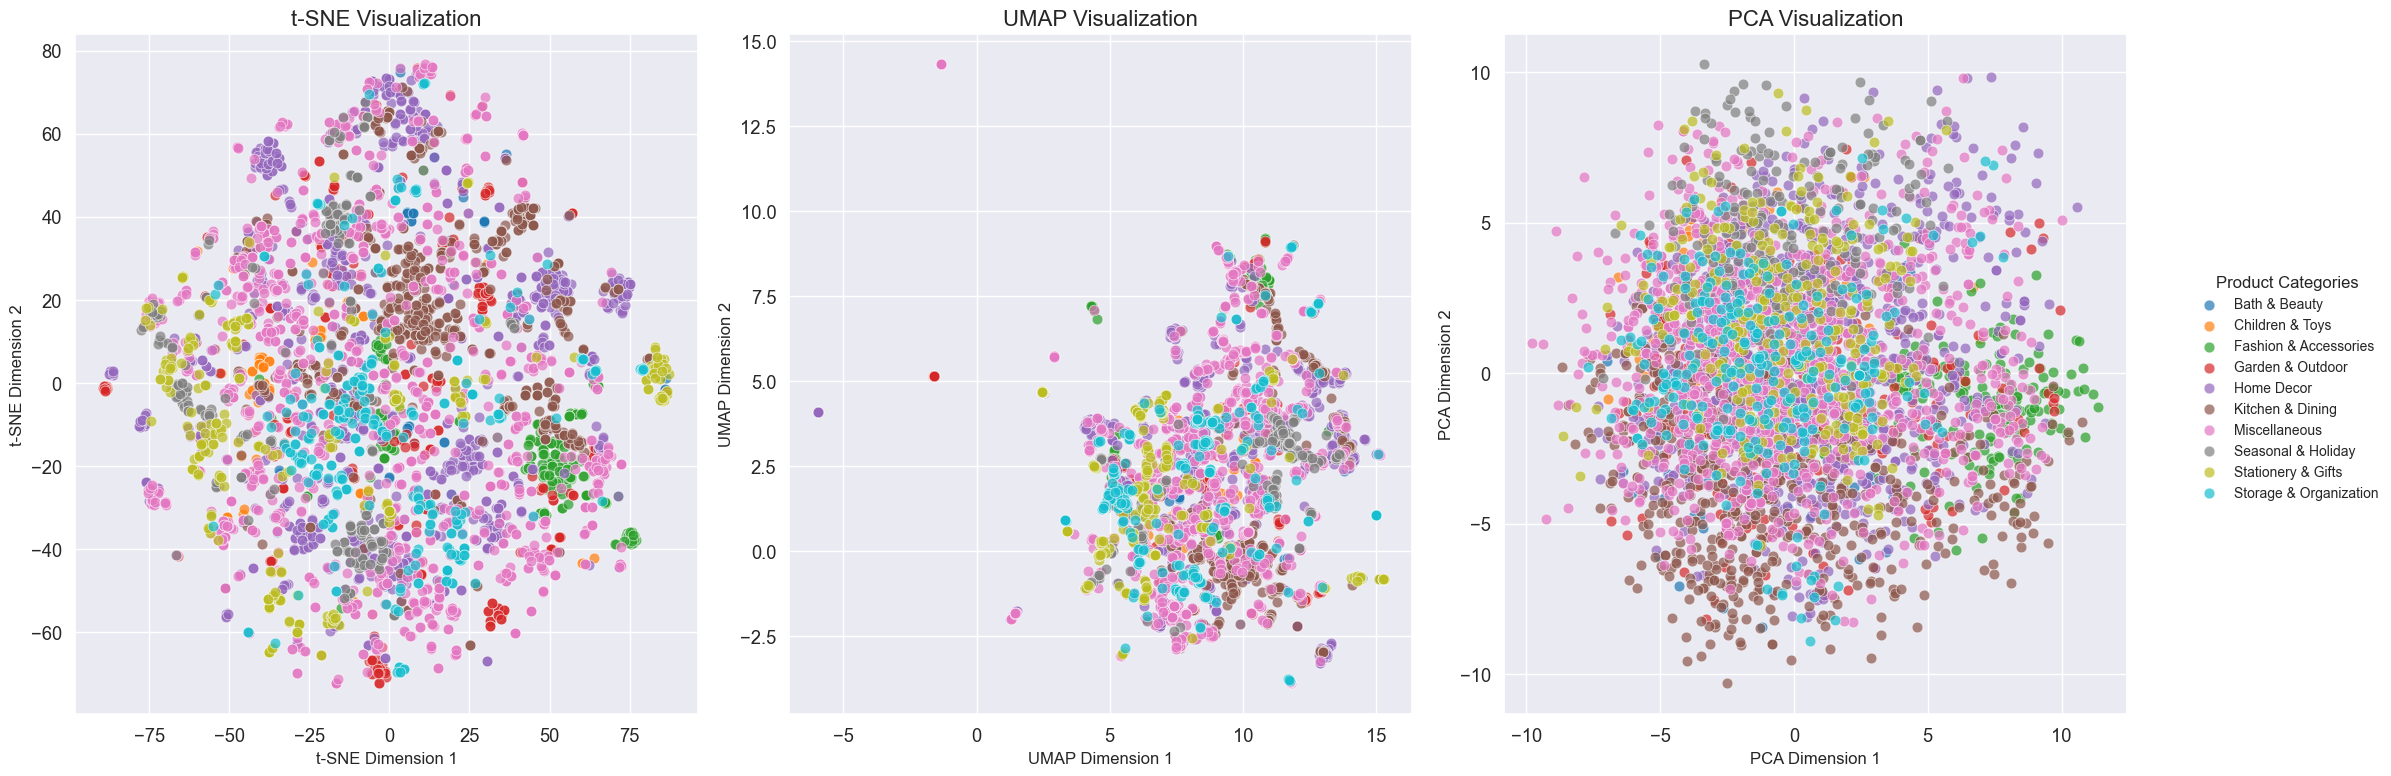


Analyzing clusters from t-SNE...

Category distribution in t-SNE clusters:

Cluster 0 (Size: 360):
  Home Decor: 105 products (29.2%)
  Miscellaneous: 99 products (27.5%)
  Storage & Organization: 47 products (13.1%)
  Garden & Outdoor: 30 products (8.3%)
  Stationery & Gifts: 24 products (6.7%)
  Kitchen & Dining: 23 products (6.4%)
  Fashion & Accessories: 20 products (5.6%)
  Representative products:
    • SWEETHEART CREAM STEEL TABLE RECT (Category: Bath & Beauty)
    • STEEL SWEETHEART ROUND TABLE CREAM (Category: Bath & Beauty)
    • S/3 PINK SQUARE PLANTERS ROSES (Category: Miscellaneous)

Cluster 1 (Size: 472):
  Miscellaneous: 195 products (41.3%)
  Home Decor: 157 products (33.3%)
  Seasonal & Holiday: 44 products (9.3%)
  Garden & Outdoor: 33 products (7.0%)
  Representative products:
    • UNION STRIPE WITH FRINGE  HAMMOCK (Category: Miscellaneous)
    • OCEAN STRIPE HAMMOCK  (Category: Miscellaneous)
    • SET 3 PAPER VINTAGE CHICK PAPER EGG (Category: Home Decor)

Cluste

In [8]:
from sklearn.cluster import KMeans

def apply_dimensionality_reduction(embeddings):
    """Apply multiple dimensionality reduction techniques for comparison"""
    print("\nApplying dimensionality reduction techniques...")
    
    # Scale embeddings
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    results = {}
    
    # 1. t-SNE
    print("Running t-SNE...")
    perplexity = min(30, len(embeddings) - 1)  # Ensure perplexity isn't too large
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        learning_rate='auto',
        random_state=42
    )
    results['t-SNE'] = tsne.fit_transform(scaled_embeddings)
    
    # 2. UMAP
    print("Running UMAP...")
    umap_reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine',
        random_state=42
    )
    results['UMAP'] = umap_reducer.fit_transform(scaled_embeddings)
    
    # 3. PCA
    print("Running PCA...")
    pca = PCA(n_components=2, random_state=42)
    results['PCA'] = pca.fit_transform(scaled_embeddings)
    
    print("Dimensionality reduction completed.")
    return results

def create_comparison_visualization(dim_reduction_results, categories, descriptions, category_names):
    """Create and save visualizations for all three dimensionality reduction methods"""
    print("\nCreating comparison visualizations...")
    
    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Create a color palette (using a good categorical palette)
    palette = sns.color_palette("tab10", len(category_names))
    color_map = {cat: color for cat, color in zip(category_names, palette)}
    
    # Titles for each subplot
    titles = ['t-SNE', 'UMAP', 'PCA']
    
    # Create plots for each method
    plot_dfs = {}
    
    for i, (method, embedding) in enumerate(dim_reduction_results.items()):
        # Create DataFrame for plotting
        plot_df = pd.DataFrame({
            'x': embedding[:, 0],
            'y': embedding[:, 1],
            'category': categories,
            'description': descriptions
        })
        
        plot_dfs[method] = plot_df
        
        # Plot each category
        for category in category_names:
            subset = plot_df[plot_df['category'] == category]
            if not subset.empty:
                axes[i].scatter(
                    subset['x'], subset['y'],
                    label=category if i == 0 else None,  # Only add label to first plot
                    color=color_map[category],
                    alpha=0.7,
                    s=60,
                    edgecolors='white',
                    linewidth=0.5
                )
        
        # Add title and labels
        axes[i].set_title(f'{method} Visualization', fontsize=16)
        axes[i].set_xlabel(f'{method} Dimension 1', fontsize=12)
        axes[i].set_ylabel(f'{method} Dimension 2', fontsize=12)
    
    # Add single legend on the right side
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Product Categories', 
              loc='center right', fontsize=10, title_fontsize=12)
    
    # Improve layout
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust for legend
    
    # Save the plot
    plt.savefig('dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')
    print("Comparison visualization saved as 'dimensionality_reduction_comparison.png'")
    
    # Show the plot
    plt.show()
    
    return plot_dfs

def analyze_clusters(plot_df, category_names, method_name="t-SNE"):
    """Analyze the clusters and their category compositions"""
    print(f"\nAnalyzing clusters from {method_name}...")
    # Determine optimal number of clusters (using one per category is reasonable)
    n_clusters = len(category_names)
    
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    plot_df['cluster'] = kmeans.fit_predict(plot_df[['x', 'y']])
    
    # Analyze category distribution in each cluster
    print(f"\nCategory distribution in {method_name} clusters:")
    for cluster_id in range(n_clusters):
        cluster_data = plot_df[plot_df['cluster'] == cluster_id]
        total = len(cluster_data)
        
        print(f"\nCluster {cluster_id} (Size: {total}):")
        category_counts = cluster_data['category'].value_counts()
        
        for category, count in category_counts.items():
            percentage = (count / total) * 100
            if percentage >= 5:  # Only show categories that make up at least 5% of the cluster
                print(f"  {category}: {count} products ({percentage:.1f}%)")
        
        # Find representative products
        centroid = kmeans.cluster_centers_[cluster_id]
        cluster_data['distance_to_centroid'] = cluster_data.apply(
            lambda row: np.sqrt((row['x'] - centroid[0])**2 + (row['y'] - centroid[1])**2), 
            axis=1
        )
        
        # Get 3 most representative products
        representatives = cluster_data.nsmallest(3, 'distance_to_centroid')
        
        print("  Representative products:")
        for _, row in representatives.iterrows():
            print(f"    • {row['description']} (Category: {row['category']})")

def compare_methods(plot_dfs, category_names):
    """Compare the effectiveness of different dimensionality reduction methods"""
    print("\nComparing dimensionality reduction methods...")
    
    from sklearn.metrics import silhouette_score
    
    # Calculate silhouette scores for each method
    silhouette_scores = {}
    
    for method, plot_df in plot_dfs.items():
        # Use K-means to identify clusters
        kmeans = KMeans(n_clusters=len(category_names), random_state=42)
        clusters = kmeans.fit_predict(plot_df[['x', 'y']])
        
        # Calculate silhouette score
        try:
            score = silhouette_score(plot_df[['x', 'y']], plot_df['category'])
            silhouette_scores[method] = score
            print(f"  {method} silhouette score: {score:.4f}")
        except:
            print(f"  Unable to calculate silhouette score for {method}")
    
    # Find the method with the highest silhouette score
    if silhouette_scores:
        best_method = max(silhouette_scores, key=silhouette_scores.get)
        print(f"\nBased on silhouette scores, {best_method} provides the best clustering with a score of {silhouette_scores[best_method]:.4f}")
    
    # Calculate separation between category centroids for each method
    for method, plot_df in plot_dfs.items():
        print(f"\nCategory separation in {method}:")
        
        # Calculate centroids for each category
        centroids = {}
        for category in category_names:
            subset = plot_df[plot_df['category'] == category]
            if len(subset) > 0:
                centroids[category] = (subset['x'].mean(), subset['y'].mean())
        
        # Calculate average distance between centroids
        distances = []
        for i, cat1 in enumerate(category_names):
            if cat1 not in centroids:
                continue
            for cat2 in category_names[i+1:]:
                if cat2 not in centroids:
                    continue
                dist = np.sqrt((centroids[cat1][0] - centroids[cat2][0])**2 + 
                             (centroids[cat1][1] - centroids[cat2][1])**2)
                distances.append(dist)
        
        if distances:
            avg_distance = sum(distances) / len(distances)
            print(f"  Average distance between category centroids: {avg_distance:.4f}")

# Load data
df = load_data()

# Preprocess data
df_clean = preprocess_data(df)

# Prepare product data and classify into categories
descriptions, categories, stock_codes, unique_products = prepare_product_data(df_clean)

# Get unique category names
category_names = sorted(set(categories))

# Create embeddings
embeddings = create_embeddings(descriptions)

# Apply dimensionality reduction
dim_reduction_results = apply_dimensionality_reduction(embeddings)

# Create comparison visualization
plot_dfs = create_comparison_visualization(dim_reduction_results, categories, descriptions, category_names)

# Analyze clusters for each method
for method, plot_df in plot_dfs.items():
    analyze_clusters(plot_df, category_names, method)

# Compare methods
compare_methods(plot_dfs, category_names)

print("\nAnalysis complete!")